In [2]:
import h5py
import scipy
import scipy.io
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import FFMpegWriter
from IPython.display import HTML
rc('animation', html='html5')
%matplotlib inline 

from scipy.stats import norm

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow
tfl = tf.linalg

In [3]:
balls = scipy.io.loadmat('/Users/robertofiermonte/bouncing_balls_training_data.mat')
y = np.clip(np.stack([b for b in balls['Data'].flatten()]), 0.001, 0.999)

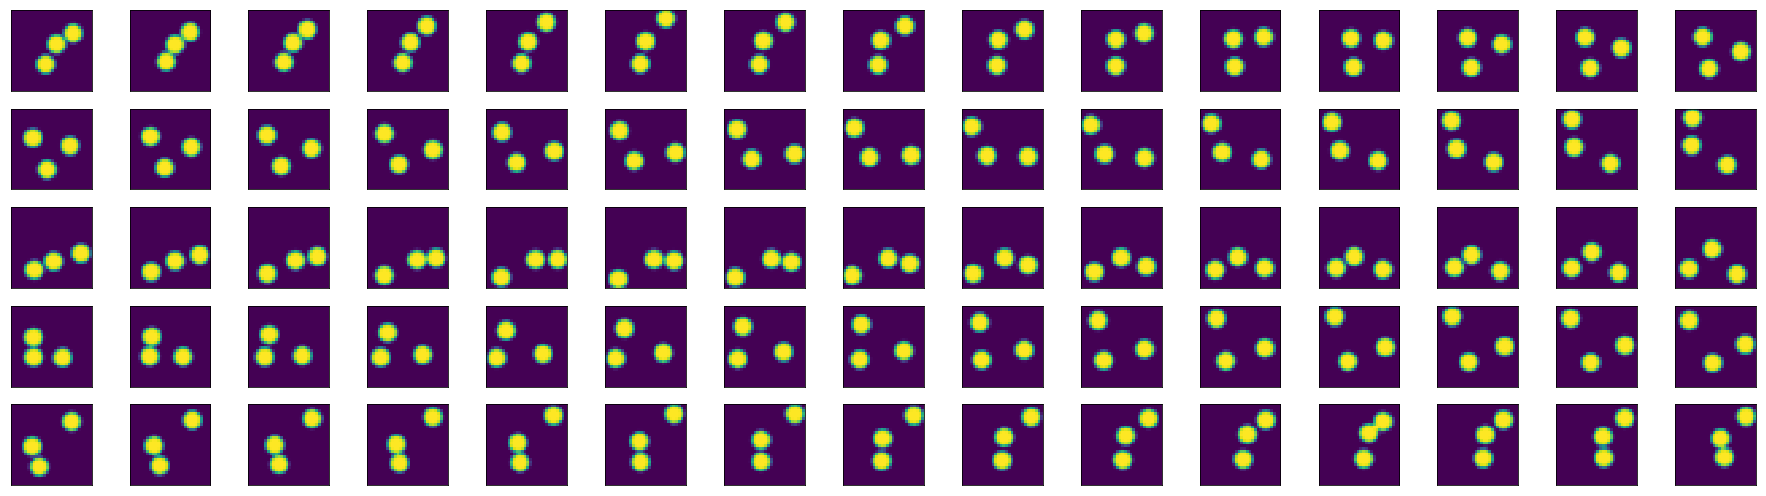

In [4]:
fig, axs = plt.subplots(nrows=5, ncols=15, figsize=(25, 7))
for i in range(5):
    for j in range(15):
        axs[i][j].imshow(np.reshape(y[i], [100, 30, 30])[j])
        axs[i][j].set_xticks([]); axs[i][j].set_yticks([])
plt.tight_layout()
plt.show()

In [77]:
# noise = norm.rvs(0, 1.2, y.shape)
# y_noisy = np.clip(norm.cdf(norm.ppf(y) + noise), 0.001, 0.999)
# training_data = norm.ppf(y_noisy)

# fig, axs = plt.subplots(nrows=5, ncols=15, figsize=(25, 7))
# for i in range(5):
#     for j in range(15):
#         axs[i][j].imshow(np.reshape(y_noisy[i], [100, 30, 30])[j])
#         axs[i][j].set_xticks([]); axs[i][j].set_yticks([])
# plt.tight_layout()
# plt.show()

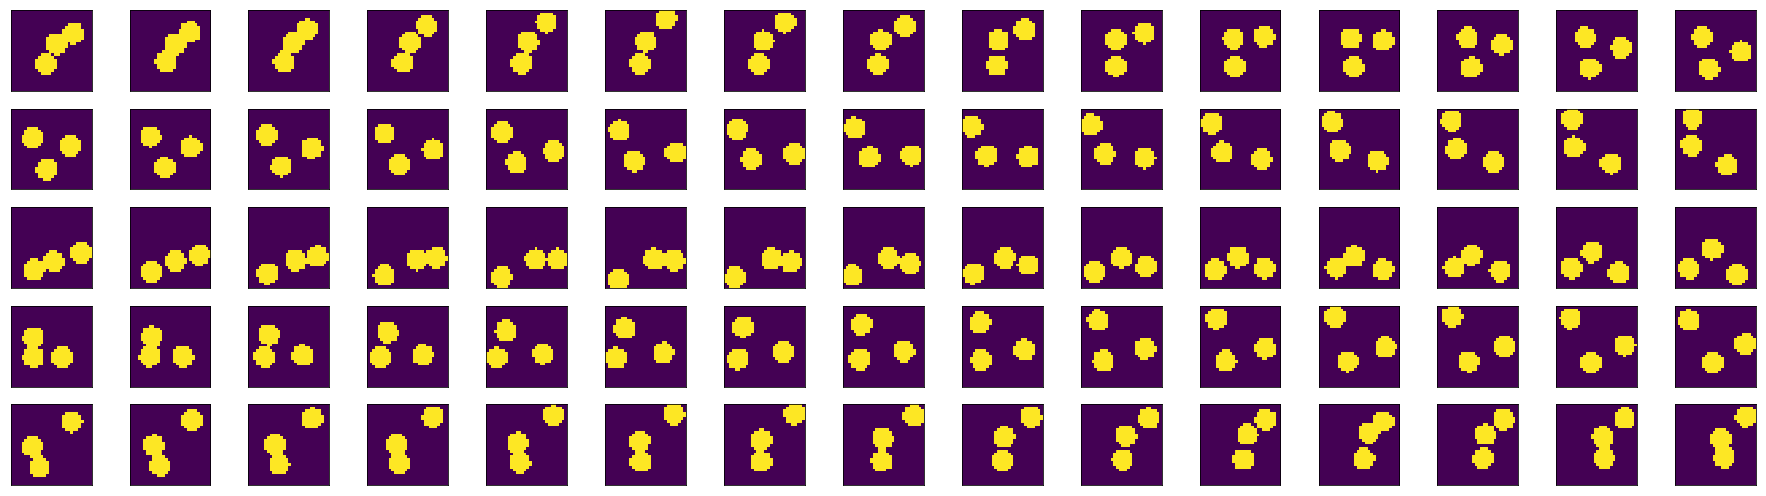

In [5]:
y_bw = np.where(y > 0.1, 1, 0)

fig, axs = plt.subplots(nrows=5, ncols=15, figsize=(25, 7))
for i in range(5):
    for j in range(15):
        axs[i][j].imshow(np.reshape(y_bw[i], [100, 30, 30])[j])
        axs[i][j].set_xticks([]); axs[i][j].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [7]:
class BernoulliVideoCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, hidden_size, reuse=None):       
        super(BernoulliVideoCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._hidden_size = hidden_size

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return self._event_size

    def call(self, inputs, state):
        _, state = self._cell(inputs, state)
        hidden = tf.layers.dense(state, self._hidden_size, tf.nn.relu)
        hidden = tf.layers.dense(hidden, self._hidden_size, tf.nn.relu)
        mean = tf.layers.dense(hidden, self._event_size, tf.nn.sigmoid)
        return mean, state
    
class SamplingVideoCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingVideoCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return self._output_size

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        mean, state = self._cell(sample, state)
        sample = tfd.Bernoulli(mean).sample()
        return mean, (state, sample)

In [55]:
class RobustVideoARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=100, batch_size=1):
        self._data = data                                         # B x T x D
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 900                                             # D
        self._H = n_hidden                                        # H
        self._S = n_samples                                       # S
        
        self._cell = tf.contrib.rnn.GRUBlockCell(self._H)
        self._bernoulli_cell = BernoulliVideoCell(self._cell, self._D, 200)
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self.make_posterior
        self.compute_elbo
        self.E_step
        self.M_step
        
#         self.make_forward_posterior
#         self.make_forward_parameters
#         self.compute_elbo_forward
#         self.forward_E_step
#         self.forward_M_step
    
    @define_scope
    def make_posterior(self):
        self._post_cell_f = tf.contrib.rnn.GRUBlockCell(self._H)
        self._post_cell_b = tf.contrib.rnn.GRUBlockCell(self._H)
        (out_f, out_b), _ = tf.nn.bidirectional_dynamic_rnn(
                                                self._post_cell_f, self._post_cell_b, 
                                                inputs=self._data, dtype=tf.float32
        )
        
        hidden = tf.concat([out_f, out_b], 2)
        means = tf.layers.dense(hidden, 200, tf.nn.relu)
        means = tf.layers.dense(means, 200, tf.nn.relu)
        means = tf.layers.dense(means, self._D, tf.nn.sigmoid)
        means = tf.identity(means, name='post_means')
        return tfd.Bernoulli(means)
    
    @define_scope
    def make_entropy_y(self):
        pi = self.make_posterior.mean()
        return tf.reduce_sum(-pi * tf.log(pi) - (1 - pi) * tf.log(1 - pi))
    
    @define_scope
    def make_kl_y(self):
        q = self.make_posterior.mean()
        p = self.make_transitional
        kl =  q * (tf.log(q) - tf.log(p)) + (1 - q) * (tf.log(1 - q) - tf.log(1 - p))
        return tf.reduce_sum(tf.reduce_mean(kl, 0))
    
    @define_scope
    def make_transitional(self):
        code = tf.reshape(self._code, [-1, self._T, self._D])
        inputs = tf.concat([tf.zeros((self._B * self._S, 1, self._D)), code[:, :-1]], 1)
        means, _ = tf.nn.dynamic_rnn(self._bernoulli_cell, inputs=inputs, dtype=tf.float32)
        return tf.reshape(means, [self._S, self._B, self._T, self._D])
    
    @define_scope
    def make_reconstruction(self):
        code = self._code
        means = tf.layers.dense(code, 200, tf.nn.relu)
        means = tf.layers.dense(means, 200, tf.nn.relu)
        means = tf.layers.dense(means, self._D, tf.nn.sigmoid)
        return tf.reduce_sum(tf.reduce_mean(self._data[None, ...] * means 
                                            + (1 - self._data[None, ...]) * (1 - means), 0))
    
    @define_scope
    def compute_elbo(self):      
        posterior = self.make_posterior
        self._code = tf.to_float(posterior.sample((self._S))) # S x B x T x D
        
        entropy = self.make_entropy_y   
        kl = self.make_kl_y
        reconstruction = self.make_reconstruction     
        loss = reconstruction - kl
        
        return loss, kl, reconstruction, entropy

    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=non_post_var)
    
    @define_scope
    def make_forward_posterior(self):
        mean = tf.nn.sigmoid(tf.get_variable(shape=(self._D), initializer=tf.constant_initializer(0), 
                                                 name='forward_y_mean'))
        return tfd.Bernoulli(mean)

    @define_scope
    def make_forward_parameters(self):
        return tf.get_variable(shape=(50, self._D), name='best_forward_sequence', 
                               initializer=tf.constant_initializer(0))
    
    @define_scope
    def compute_forward_message(self):
        h = tf.zeros((self._S, self._H))                                       # S x H
        code = self._code                                                      # S x B x T x D
        code = code[:, 0, ...]                                                 # S x T x D
        for t in range(self._T):
            _, h = self._cell(code[:, t], h)
            h = tf.tile(tf.reduce_mean(h, 0, keepdims=True), [self._S, 1])
        
        dist_y = tfd.MultivariateNormalDiag(self.make_posterior.mean()[-1], 
                                            scale_identity_multiplier=self._post_std)
        return dist_y, h
    
    @define_scope
    def make_rnn_forward(self):
        _, hT = self.compute_forward_message
        hT = tf.tile(tf.reduce_mean(hT, 0, keepdims=True), [self._S, 1])
        fake_inputs = tf.zeros((self._S, 50, self._D))
        post_samples = self.make_forward_posterior.sample((self._S))
        (means, stddevs), _ = tf.nn.dynamic_rnn(self._sampling_cell, inputs=fake_inputs, 
                                                initial_state=(hT, post_samples[..., None]))
        return means, stddevs
    
    @define_scope
    def compute_elbo_forward(self):
        self._sampling_cell = SamplingVideoCell(self._gauss_cell, self._D, self._S)
        
        post = self.make_forward_posterior
        post_samples = post.sample((self._S))
        entropy = tf.log(tf.square(post.scale[0, 0]))
        
        dist_y, _ = self.compute_forward_message
        means, stddevs = self.make_rnn_forward
        
        pred = self.make_forward_parameters
        reconstruction_exp = tf.square(pred[None, :] - means[..., 0])/tf.square(stddevs[..., 0])
        reconstruction_norm = tf.reduce_sum(tf.reduce_mean(tf.log(tf.square(stddevs)), 0))
        reconstruction = - tf.reduce_mean(tf.reduce_sum(reconstruction_exp, -1)) - reconstruction_norm
        
        cross = tf.square(dist_y.mean() - post_samples)/tf.square(dist_y.scale)
        kl = - entropy + tf.reduce_mean(cross) + tf.log(tf.square(dist_y.scale))
        
        return reconstruction - kl, kl, reconstruction, entropy
    
    @define_scope
    def forward_E_step(self):
        post_var = [v for v in tf.trainable_variables() if 'make_forward_posterior' in v.name]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)
    
    @define_scope
    def forward_M_step(self):
        post_var = [v for v in tf.trainable_variables() if 'make_forward_parameters' in v.name]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)

In [56]:
tf.reset_default_graph()

seq_length = 70; n_samples = 100; batch_size = 1;
data = np.float32(y_bw[:batch_size, :seq_length])
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 900])

gen_model = RobustVideoARGenerator(x_, n_hidden=100, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

elbos = []; kls = []; llks = []; means = []; post_samples = []; post_means = []

for i in range(25001):
    batch = data[:batch_size]
    
    elbo, kl, llk, entropy = sess.run(gen_model.compute_elbo, {x_: batch})
    elbos.append(elbo); kls.append(kl); llks.append(llk)
    means_op = tf.get_default_graph().get_tensor_by_name('make_posterior/post_means:0')
    post_means.append(sess.run(means_op, {x_: batch})[0])
    m = sess.run(gen_model.make_transitional, {x_: batch}); means.append(m)
    latents = sess.run(gen_model._code, {x_: batch})
    post_samples.append(latents)
    
    if i % 10 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Entropy:', entropy)
    
    sess.run(gen_model.E_step, {x_: batch})
    sess.run(gen_model.M_step, {x_: batch})

(1, 70, 900)


KeyboardInterrupt: 

In [17]:
# tf.train.Saver().save(sess, '/Users/robertofiermonte/Repository/model_{}.ckpt'.format(batch_size))
for i in range(15001):   
    elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: batch[..., None]})
    sess.run(gen_model.forward_E_step, {x_: batch[..., None]})
    sess.run(gen_model.forward_M_step, {x_: batch[..., None]})
    
    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward)

Iteration: 0 ELBO Forward: (-54.824703, 58.613407, 3.788704, 1.5093575)
Iteration: 1000 ELBO Forward: (93.909676, 8.102896, 102.01257, -0.11760562)
Iteration: 2000 ELBO Forward: (99.70742, 2.3454762, 102.052895, -0.9071805)
Iteration: 3000 ELBO Forward: (100.49086, 1.6507232, 102.14159, -1.4873345)
Iteration: 4000 ELBO Forward: (101.29979, 1.0492444, 102.34904, -1.9133987)
Iteration: 5000 ELBO Forward: (101.053604, 1.1369095, 102.19051, -2.1837652)
Iteration: 6000 ELBO Forward: (100.88087, 1.3502603, 102.231125, -2.3202813)
Iteration: 7000 ELBO Forward: (100.98634, 1.279026, 102.26537, -2.33623)
Iteration: 8000 ELBO Forward: (101.299355, 0.96702504, 102.26638, -2.3368955)
Iteration: 9000 ELBO Forward: (101.178215, 1.0388188, 102.21703, -2.3472033)
Iteration: 10000 ELBO Forward: (101.529076, 0.7999785, 102.329056, -2.353447)
Iteration: 11000 ELBO Forward: (101.17851, 1.0450525, 102.223564, -2.3467817)
Iteration: 12000 ELBO Forward: (101.25317, 0.98739934, 102.24056, -2.3531969)
Iteratio

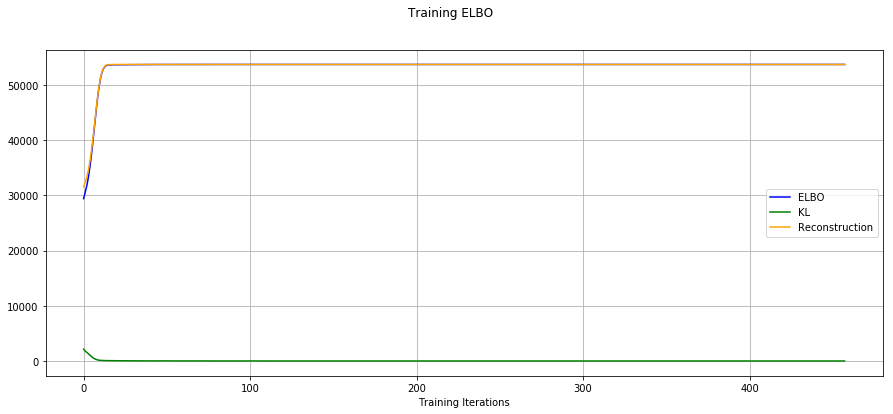

In [24]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(kls, 'g', label='KL')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(entropy)
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(1, 70, 900), dtype=float32) is not an element of this graph.

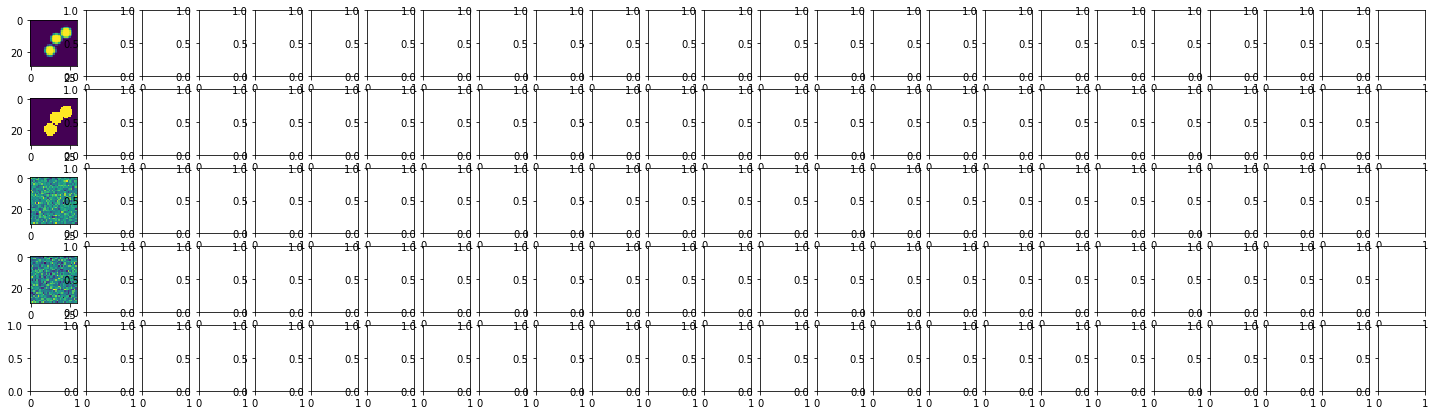

In [65]:
fig, axs = plt.subplots(nrows=5, ncols=25, figsize=(25, 7))
for j in range(25):
    axs[0][j].imshow(np.reshape(y[0], [100, 30, 30])[j])    
    axs[1][j].imshow(np.reshape(y_bw[0], [100, 30, 30])[j])    
    axs[2][j].imshow(np.reshape(np.mean(means[-1], 0), [70, 30, 30])[j])
    axs[3][j].imshow(np.reshape(np.mean(latents[:, 0], 0), [70, 30, 30])[j])
    axs[4][j].imshow(np.reshape(sess.run(gen_model.make_posterior.mean(), {x_: batch})[0], [70, 30, 30])[j])
for i in range(5):
    for j in range(25):
        axs[i][j].set_xticks([]); axs[i][j].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
# Best forward pred at 10000 iters
code = sess.run(gen_model.make_forward_parameters, {x_: batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(15, 6))
plt.plot(y_tilde[0, :seq_length], label='noisy data')
plt.plot(np.concatenate([y[:seq_length, 0], code], 0), 'r', label='prediction')
plt.plot(y[:seq_length+50], label='clean data')
plt.legend()
plt.suptitle("Best forward prediction");

0) Implement Forward Prediction

1) Use binarised sequence as noisy data 

2) Test other RNNs

3) Model Bernoulli means